In [1]:
import pandas as pd

Load data

In [2]:
# Load data from the CSV file into a new DataFrame
data = pd.read_csv('./model/gps_data.csv')
data

,Latitude,Longitude,0,Altitude,NumDays,Date,Time
0,39.984702,116.318417,0,492.000000,39744.120185,2008-10-23,02:53:04
1,39.984683,116.318450,0,492.000000,39744.120255,2008-10-23,02:53:10
2,39.984686,116.318417,0,492.000000,39744.120313,2008-10-23,02:53:15
3,39.984688,116.318385,0,492.000000,39744.120370,2008-10-23,02:53:20
4,39.984655,116.318263,0,492.000000,39744.120428,2008-10-23,02:53:25
...,...,...,...,...,...,...,...
24876973,40.914867,111.710500,0,3802.493438,39521.152731,2008-03-14,03:39:56
24876974,40.914267,111.710333,0,3795.931759,39521.153669,2008-03-14,03:41:17
24876975,40.912467,111.710667,0,3795.931759,39521.154884,2008-03-14,03:43:02
24876976,40.911517,111.711317,0,3779.527559,39521.155185,2008-03-14,03:43:28


Load transportation data

In [3]:
# Load data from the CSV file into a new DataFrame
data_labels = pd.read_csv('./model/labels_data.csv')
data_labels

,Start Time,End Time,Transportation Mode
0,2007/06/26 11:32:29,2007/06/26 11:40:29,bus
1,2008/03/28 14:52:54,2008/03/28 15:59:59,train
2,2008/03/28 16:00:00,2008/03/28 22:02:00,train
3,2008/03/29 01:27:50,2008/03/29 15:59:59,train
4,2008/03/29 16:00:00,2008/03/30 15:59:59,train
...,...,...,...
14713,2008/11/17 06:59:58,2008/11/17 07:06:16,bus
14714,2008/11/17 07:06:16,2008/11/17 07:14:32,walk
14715,2008/11/29 01:58:05,2008/11/29 02:01:39,bus
14716,2008/11/29 02:01:39,2008/11/29 02:07:57,walk


Bar charts and histograms

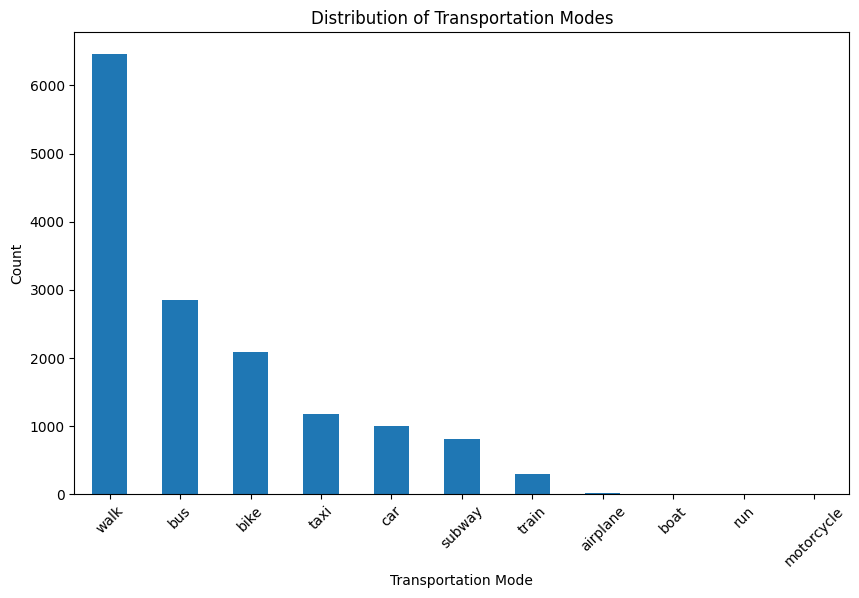

In [4]:
import matplotlib.pyplot as plt

x = data_labels['Transportation Mode'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
x.plot(kind='bar')
plt.xlabel('Transportation Mode')
plt.ylabel('Count')
plt.title('Distribution of Transportation Modes')
plt.xticks(rotation=45)
plt.show()
